In [1]:
from IPython.display import clear_output


! pip install yfinance

! pip install sktime

! pip install skforecast

! pip install keras-tuner --upgrade

!pip install seaborn


clear_output()

In [2]:
import pandas as pd
import numpy as np
import yfinance as yf

import time

from sktime.forecasting.model_selection import temporal_train_test_split
from sklearn.model_selection import TimeSeriesSplit
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sktime.utils.plotting import plot_series
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.linear_model import SGDRegressor
from sklearn.metrics import r2_score
from sklearn.svm import SVR
from sklearn.ensemble import StackingRegressor

from skforecast.ForecasterAutoregCustom import ForecasterAutoregCustom
from skforecast.ForecasterAutoregDirect import ForecasterAutoregDirect
from skforecast.ForecasterAutoreg import ForecasterAutoreg
from skforecast.model_selection import grid_search_forecaster
from skforecast.model_selection import backtesting_forecaster
from sklearn.metrics import mean_absolute_error
from skforecast.utils import save_forecaster
from skforecast.utils import load_forecaster
import warnings
warnings.filterwarnings('ignore')

from sktime.forecasting.exp_smoothing import ExponentialSmoothing
from sktime.forecasting.ets import AutoETS
from sktime.forecasting.base import ForecastingHorizon

import tensorflow as tf
import tensorflow.keras.backend as K 
from joblib import dump, load
import random as rn
import os
# from tensorflow import set_random_seed
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint


# from statsmodels.tsa.holtwinters import ExponentialSmoothing
from keras.layers import Dense, LSTM, LeakyReLU, Dropout, ReLU
from keras.layers import Bidirectional

import keras_tuner


from tqdm import tqdm
import matplotlib.pyplot as plt

In [3]:
data_btc_oh = yf.download(tickers='BTC-USD', start="2014-01-01", end="2023-06-15", interval = '1d', ).iloc[:, [0, 1, 2,3,5]]
data_btc_oh

[*********************100%***********************]  1 of 1 completed


,Open,High,Low,Close,Volume
Date,,,,,
2014-09-17,465.864014,468.174011,452.421997,457.334015,21056800
2014-09-18,456.859985,456.859985,413.104004,424.440002,34483200
2014-09-19,424.102997,427.834991,384.532013,394.795990,37919700
2014-09-20,394.673004,423.295990,389.882996,408.903992,36863600
2014-09-21,408.084991,412.425995,393.181000,398.821014,26580100
...,...,...,...,...,...
2023-06-10,26481.761719,26531.044922,25501.835938,25851.240234,19872933189
2023-06-11,25854.031250,26203.439453,25668.986328,25940.167969,10732609603
2023-06-12,25934.285156,26087.919922,25675.197266,25902.500000,11677889997


In [4]:
new_series = [0]
for i in tqdm(range(1, len(data_btc_oh))):
    k = 0
    for j in range(0, i):
        if data_btc_oh.Close[i] >= data_btc_oh.Close[j]:
            k += 1
    new_series.append(k)
    
data_btc_oh['stability'] = new_series

proper_series = np.arange(0, len(data_btc_oh))

data_btc_oh['proper'] = proper_series
data_btc_oh
percentage = np.sum(data_btc_oh.iloc[:, -2]) / np.sum(data_btc_oh.iloc[:, -1])
print(f'sustainability = {percentage:.2%}')

100%|██████████████████████████████████████████████████████████████████████████████| 3192/3192 [03:50<00:00, 13.85it/s]

sustainability = 87.34%


In [5]:
data_btc_oh

,Open,High,Low,Close,Volume,stability,proper
Date,,,,,,,
2014-09-17,465.864014,468.174011,452.421997,457.334015,21056800,0,0
2014-09-18,456.859985,456.859985,413.104004,424.440002,34483200,0,1
2014-09-19,424.102997,427.834991,384.532013,394.795990,37919700,0,2
2014-09-20,394.673004,423.295990,389.882996,408.903992,36863600,1,3
2014-09-21,408.084991,412.425995,393.181000,398.821014,26580100,1,4
...,...,...,...,...,...,...,...
2023-06-10,26481.761719,26531.044922,25501.835938,25851.240234,19872933189,2570,3188
2023-06-11,25854.031250,26203.439453,25668.986328,25940.167969,10732609603,2571,3189
2023-06-12,25934.285156,26087.919922,25675.197266,25902.500000,11677889997,2571,3190


In [6]:
data_btc_oh['drawdowns'] = data_btc_oh['proper'] - data_btc_oh['stability']
data_btc_oh

,Open,High,Low,Close,Volume,stability,proper,drawdowns
Date,,,,,,,,
2014-09-17,465.864014,468.174011,452.421997,457.334015,21056800,0,0,0
2014-09-18,456.859985,456.859985,413.104004,424.440002,34483200,0,1,1
2014-09-19,424.102997,427.834991,384.532013,394.795990,37919700,0,2,2
2014-09-20,394.673004,423.295990,389.882996,408.903992,36863600,1,3,2
2014-09-21,408.084991,412.425995,393.181000,398.821014,26580100,1,4,3
...,...,...,...,...,...,...,...,...
2023-06-10,26481.761719,26531.044922,25501.835938,25851.240234,19872933189,2570,3188,618
2023-06-11,25854.031250,26203.439453,25668.986328,25940.167969,10732609603,2571,3189,618
2023-06-12,25934.285156,26087.919922,25675.197266,25902.500000,11677889997,2571,3190,619


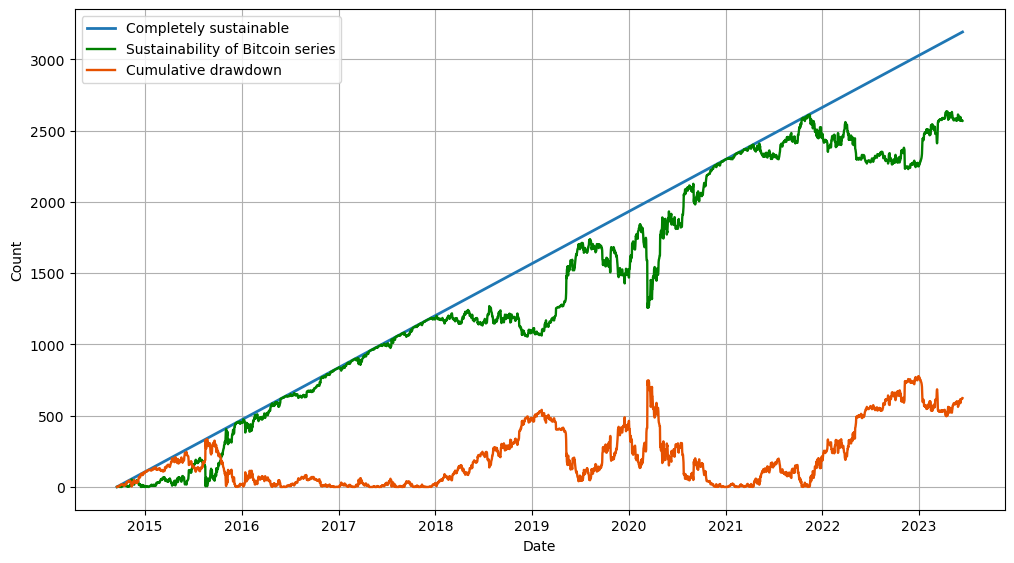

In [12]:
plt.figure(figsize=(12,6.5))
plt.plot(data_btc_oh.index[1:], data_btc_oh.iloc[1:, -2], label='Completely sustainable', lw=2)
plt.plot(data_btc_oh.index[1:], data_btc_oh.iloc[1:, -3], label='Sustainability of Bitcoin series', lw=1.7, c='green')

plt.plot(data_btc_oh.index[1:], data_btc_oh.iloc[1:, -1], label='Cumulative drawdown', lw=1.7, c='#E65100')

plt.xlabel('Date')
plt.ylabel('Count')
plt.legend()
plt.grid()
# plt.show()
# saving the figure.
plt.savefig("squares1.png",
            bbox_inches ="tight",
            pad_inches = 0.1,
            orientation ='landscape')

In [13]:
added_column_version = 'drawdowns'

data_btc_oh = data_btc_oh[['Open', 'High', 'Low',  'Volume', added_column_version, 'Close']]
data_btc_oh

,Open,High,Low,Volume,drawdowns,Close
Date,,,,,,
2014-09-17,465.864014,468.174011,452.421997,21056800,0,457.334015
2014-09-18,456.859985,456.859985,413.104004,34483200,1,424.440002
2014-09-19,424.102997,427.834991,384.532013,37919700,2,394.795990
2014-09-20,394.673004,423.295990,389.882996,36863600,2,408.903992
2014-09-21,408.084991,412.425995,393.181000,26580100,3,398.821014
...,...,...,...,...,...,...
2023-06-10,26481.761719,26531.044922,25501.835938,19872933189,618,25851.240234
2023-06-11,25854.031250,26203.439453,25668.986328,10732609603,618,25940.167969
2023-06-12,25934.285156,26087.919922,25675.197266,11677889997,619,25902.500000


In [14]:
STEPS = 1
time_series_train, time_series_test = data_btc_oh[data_btc_oh.index <= "2022-03-01"], data_btc_oh[data_btc_oh.index > "2022-03-01"]

# LSTM training

In [17]:
from keras.utils import np_utils
from tensorflow.keras.layers import RepeatVector, TimeDistributed
from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras.regularizers import l2



# define SMAPE loss function
def smape_loss(y_true, y_pred):
    epsilon = 0.001
    summ = K.maximum(K.abs(y_true) + K.abs(y_pred) + epsilon, 0.5 + epsilon)
    smape = K.abs(y_pred - y_true) / summ * 2.0
    return smape * 100

In [18]:
# define function for preparing data for LSTM

def multivariate_data(dataset, target, start_index, end_index, history_size,
                      target_size, step, single_step=False):
    data = []
    labels = []

    start_index = start_index + history_size
    if end_index is None:
        end_index = len(dataset) - target_size

    for i in range(start_index, end_index):
        indices = range(i-history_size, i, step)
        data.append(dataset.iloc[indices])

        if single_step:
            labels.append(target[i + target_size - 1])
        else:
            labels.append(target[i:i+target_size])

    return np.array(data), np.array(labels)

In [1]:
# number of past observations used for prediction future value
HISTORY = 40


# train sample
dl_data_train = data_btc_oh.loc[time_series_train.index].copy() 
# validation sample
dl_data_test = data_btc_oh.iloc[-(len(time_series_test) + HISTORY):-len(time_series_test) // 2].copy() 

# define scaler
scl_y = MinMaxScaler()

# scale values
dl_data_train.iloc[:, :] = scl_y.fit_transform(dl_data_train.iloc[:, :])
dl_data_test.iloc[:, :] = scl_y.transform(dl_data_test.iloc[:, :])
# dump(scl_y, 'scaler_for_lstm_smape.save')

for i in range(1, 8, 1):
    
    
    # prepare train and val data
    X_train, y_train = multivariate_data(dl_data_train.copy(), dl_data_train.loc[:, 'Close'].copy().values, start_index=0,
                                        end_index=None, 
                                        history_size=HISTORY, 
                                        target_size=i, step=1, 
                                        single_step=True)


    X_eval, y_eval = multivariate_data(dl_data_test.copy(), dl_data_test.loc[:, 'Close'].copy(), start_index=0,
                                        end_index=None, 
                                        history_size=HISTORY, 
                                        target_size=i, step=1, 
                                        single_step=True)



    
    # define model's parameters

    BUFFER_SIZE = 10000
    BATCH_SIZE = 256


    learning_rate_ = 0.0005
    adam = tf.keras.optimizers.Adam(learning_rate=learning_rate_)

    SEED = 276148


    # fix random state 
    os.environ['PYTHONHASHSEED']=str(SEED)
    np.random.seed(SEED)
    tf.random.set_seed(SEED)
    rn.seed(SEED)
    
    # define callbacks
    reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', 
                                                     factor=0.25, patience=25, cooldown=10, min_lr=0.00009)

    checkpoint_filepath = f'./LSTM_one_step_{i}'

    checkpoint_callback = ModelCheckpoint(
     filepath=checkpoint_filepath,
     save_weights_only=False,
     monitor='val_mae',
     mode='min',
     save_best_only=True)
    
    callback_early = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=75, start_from_epoch=70)





    # Create tf.data.Dataset objects
    train_data_multi = tf.data.Dataset.from_tensor_slices((X_train, y_train))
    train_data_multi = train_data_multi.cache().shuffle(BUFFER_SIZE).batch(BATCH_SIZE).repeat()

    val_data_multi = tf.data.Dataset.from_tensor_slices((X_eval, y_eval))
    val_data_multi = val_data_multi.batch(BATCH_SIZE).repeat()


    # Define  LSTM model
    model_gpt = tf.keras.Sequential()

    model_gpt.add(tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(200,   return_sequences=True,
                                                            kernel_regularizer=l2(0.01)), input_shape=X_train.shape[-2:]))
    model_gpt.add(tf.keras.layers.Dropout(0.4))

    model_gpt.add(tf.keras.layers.LSTM(150, return_sequences=False,
                                                        kernel_regularizer=l2(0.01)))
    model_gpt.add(tf.keras.layers.Dropout(0.2))

    model_gpt.add(tf.keras.layers.Dense(48,
                                    activation='relu'))
    model_gpt.add(tf.keras.layers.Dropout( 0.45))
    
    model_gpt.add(tf.keras.layers.Dense(STEPS))


    # Compile the model
    model_gpt.compile(optimizer=adam, loss='mean_absolute_error', metrics=[smape_loss, 'mae', 'mape'])



    # Train the model
    EVALUATION_INTERVAL = 100
    EPOCHS = 350
    history = model_gpt.fit(train_data_multi, epochs=EPOCHS,
    steps_per_epoch=EVALUATION_INTERVAL, validation_data=val_data_multi, validation_steps=50, verbose=1 ,
    callbacks=[checkpoint_callback, reduce_lr, callback_early])
    
    
    clear_output()

`The code below we used to select hyperparameters using keras-tunes`

# Final model's testing

In [34]:
# load all models for each step

models = []

for i in range(1, 8):
    Trained_model = tf.keras.models.load_model(f'./LSTM_one_step_{i}', custom_objects={'smape_loss': smape_loss})
    models.append(Trained_model)

In [35]:
def smape(a, f):  #  smape score
    return 1/len(a) * np.sum(2 * np.abs(f-a) / (np.abs(a) + np.abs(f))*100)

def mda(actual: np.ndarray, predicted: np.ndarray):
    """ Mean Directional Accuracy """
    return np.mean((np.sign(actual[1:] - actual[:-1]) == np.sign(predicted[1:] - actual[:-1])).astype(int))

def make_lstm_val(md, splits_=10, horizon=7, columns_=['Open', 'High', 'Low', 'Volume', 'stability', 'Close']):
    
    HORIZON = horizon
    
    # define splitter and metric arrays
    tscv = TimeSeriesSplit(test_size=HORIZON, n_splits = splits_, max_train_size=HISTORY)
    all_smapes = []
    all_mae = []
    all_mda = []
    

    for i, (train_index, test_index) in enumerate(tscv.split(data_btc_oh.iloc[:, :-1])):
        
        # form train and test datasets
        predicts = []
        test_data_ = data_btc_oh.iloc[:, :].iloc[test_index]
        train_data_ = data_btc_oh.iloc[:, :].iloc[train_index]
        n_ = len(test_data_.columns)

        train_for_val = data_btc_oh.iloc[train_index]
        train_for_val = train_for_val[columns_]
        
        # scale 
        train_for_val = scl_y.transform(train_for_val)
        
        
        
        for j in md:
            """
            this cycle is used to create 7-day ahead prediciton
            as we use drect approach, we need 7 models for that
            """
            pred = j.predict(train_for_val[:, :].reshape(1, HISTORY, n_), verbose=0)[0].squeeze()

            for_test = pd.DataFrame(np.random.rand(STEPS, n_ - 1))
            for_test['Close'] = pd.Series(pred, name='Close')
            predicts.append(pd.DataFrame(scl_y.inverse_transform(for_test)).iloc[:, -1][0])
        
        #  as we check models performance for each step ahead prediction (From 1 to 7)
        #  we need to get specific number of predicted steps
        predict_keras = pd.Series(predicts)[:HORIZON]
        predict_keras.index = test_data_.index
        
    
        
        # calculating metrics
        mda_true = np.array([train_data_.Close.values[-1]] + list(test_data_.Close.values[:]) )
        mda_pred = np.array([train_data_.Close.values[-1]]+ list(predict_keras.values[:]))
        smape_ = smape(test_data_['Close'].values, predict_keras.values)
        mae_ = mean_absolute_error(test_data_['Close'].values, predict_keras.values)
        mda_ = mda(mda_true, mda_pred)
        
        
        
        all_smapes.append(smape_)
        all_mae.append(mae_)
        all_mda.append(mda_)



    
    # print results
    
    print(f'\nFINALE: SMAPE Mean: {np.mean(all_smapes):.2f}, MAE Mean {np.mean(all_mae):.2f}, MDA {np.mean(all_mda):.2f}' )


In [36]:
for horizont in range(1,8, 1):
    print(f'Horizont={horizont}.')
    make_lstm_val(models, 210//horizont, horizont, ['Open', 'High', 'Low', 'Volume', 'drawdowns', 'Close'])
    print()

Horizont=1.

FINALE: SMAPE Mean: 2.83, MAE Mean 625.41, MDA 0.52

Horizont=2.

FINALE: SMAPE Mean: 3.19, MAE Mean 706.46, MDA 0.52

Horizont=3.

FINALE: SMAPE Mean: 3.82, MAE Mean 842.87, MDA 0.52

Horizont=4.

FINALE: SMAPE Mean: 4.12, MAE Mean 900.93, MDA 0.54

Horizont=5.

FINALE: SMAPE Mean: 4.73, MAE Mean 1041.13, MDA 0.52

Horizont=6.

FINALE: SMAPE Mean: 5.22, MAE Mean 1123.80, MDA 0.53

Horizont=7.

FINALE: SMAPE Mean: 5.34, MAE Mean 1156.34, MDA 0.53

